In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch, torch.optim
import torch.nn.functional as F
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor
import os, sys, json, glob
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rc('image', cmap='inferno')

import random

import skimage.io
import torch.nn as nn
import argparse

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
import models.wiener_model as wm
from models.slp_model import SLP
import models.dataset as ds
from PIL import Image
import helper as hp

import scipy.io

import mat73

from scipy import signal
from skimage.metrics import structural_similarity
import statistics
import time
from datetime import datetime
import random
from scipy.io import savemat
import math

In [2]:
!gpustat

mst-hpc-kai          Wed Nov 15 18:03:03 2023  525.125.06
[0] NVIDIA RTX A6000 | 50°C,   0 % | 19323 / 49140 MB | jschoenerstedt(2846M) ysui(706M) rowe672d(2732M) escharf(13032M)
[1] NVIDIA RTX A6000 | 35°C,   0 % |  1883 / 49140 MB | tglosemeyer(1044M) tglosemeyer(836M)
[2] NVIDIA RTX A6000 | 31°C,   0 % | 33567 / 49140 MB | tglosemeyer(33562M)
[3] NVIDIA RTX A6000 | 63°C,  59 % |  1687 / 49140 MB | qzhang(1126M) escharf(556M)
[4] NVIDIA RTX A6000 | 28°C,   0 % |     5 / 49140 MB |
[5] NVIDIA RTX A6000 | 59°C,  49 % | 32951 / 49140 MB | tglosemeyer(32392M) escharf(556M)


In [3]:
parser = argparse.ArgumentParser(description='Train deconvolution network.')
parser.add_argument('--data_type', default='2D')
parser.add_argument('--network', default='multiwiener') #'wiener' or 'unet' or 'multiwiener' or 'slp'
parser.add_argument('--id', default='sim_WallerLab_norm_Diff_Circ_Unet5') #some identifier
parser.add_argument('--loss_type', default='l2') # loss function
parser.add_argument('--device', default='0') # GPU device
parser.add_argument('--psf_num', default=9, type=int) # number of initialPSFs
parser.add_argument('--psf_ds', default=1, type=float)
parser.add_argument('--epochs', default=1000, type=int) # maximum epochs
parser.add_argument('--lr', default=1e-4, type=float) # learning rate
parser.add_argument('--mbs', default=32, type=int) # mini batch size
parser.add_argument('--val_patience', default=10, type=int) # validation patience
parser.add_argument('--load_path',default=None)
parser.add_argument('--save_checkponts',default=True) # save network after each epoch
parser.add_argument('--show_valid_rec',default=True)
parser.add_argument('--save_pred',default=False) # save predictions of network
parser.add_argument('--multi_gpu',default=False) # use multiple GPUs
parser.add_argument('--psf_path',default='/media/mst32/xchange/_TG/23_PMST/Initial_PSFs_z500_fov325_532_128_128_pad.mat')
parser.add_argument('--data_path',default='/media/mst32/xchange/_TG/23_PMST/DATA_sim_WallerLab_z500_fov325_532_128_128/')

args = parser.parse_args(''.split())

filepath_save = 'saved_data/' + datetime.today().strftime('%Y-%m-%d_%H-%M-%S_') +"_".join((list(vars(args).values()))[0:5]) + "/"
if not os.path.exists(filepath_save):
    os.makedirs(filepath_save)

In [4]:
psfs = mat73.loadmat(args.psf_path)
psfs=psfs['Initial_PSFs'] 

In [5]:
if args.data_type == '3D':
    if args.network=='wiener' or args.network=='unet':
        psfs=hp.pre_process_psfs(psfs)[:,:,4]
        Ks=np.ones((32,1,1))
        print('choosing 1 psfs')

    elif args.network=='multiwiener':
        Ks=np.ones((args.psf_num,32,1,1))
        if args.psf_num==9:
            print('choosing 9 psfs')
            psfs=hp.pre_process_psfs(psfs)
    else:
        print('invalid network')
    psfs = hp.downsize_psf(psfs)
else: #2D
    if args.network=='wiener' or args.network=='unet':
        psfs=hp.pre_process_psfs_2d(psfs)[:,:,4]
        Ks= 1.
        print('choosing 1 psfs')

    elif args.network=='multiwiener':
        Ks=np.ones((args.psf_num,1,1))
        if args.psf_num==9:
            print('choosing 9 psfs')
            #psfs=hp.pre_process_psfs_2d(psfs)[...,0]
        psfs = psfs.transpose(2,0,1)
    else:
        print('invalid network')

choosing 9 psfs


In [6]:
down_size = ds.downsize(ds=args.psf_ds)
to_tensor = ds.ToTensor()
add_noise=ds.AddNoise()

filepath_train=glob.glob(args.data_path + 'Train/Truth/*')
filepath_test =glob.glob(args.data_path + 'Test/Truth/*')  
filepath_train_meas = args.data_path + 'Train/Meas/'
filepath_test_meas  = args.data_path + 'Test/Meas/'

print('training images:', len(filepath_train), 
      'testing images:', len(filepath_test))

if args.data_type == '3D':
    # not working
    dataset_train = ds.MiniscopeDataset(filepath_train, transform = transforms.Compose([down_size,add_noise,to_tensor]))
    dataset_test = ds.MiniscopeDataset(filepath_test, transform = transforms.Compose([down_size,add_noise,to_tensor]))
else:
    dataset_train = ds.MiniscopeDataset_2D(filepath_train, filepath_train_meas, transform = ds.ToTensor2d())
    dataset_test = ds.MiniscopeDataset_2D(filepath_test, filepath_test_meas, transform = ds.ToTensor2d())
    
dataloader_train = DataLoader(dataset_train, batch_size=args.mbs,
                        shuffle=True, num_workers=1)

dataloader_valid = DataLoader(dataset_test, batch_size=args.mbs,
                        shuffle=True, num_workers=1)

dataloader_test = DataLoader(dataset_test, batch_size=1,
                        shuffle=True, num_workers=1)

if args.multi_gpu == True:
    device = 'cuda'
else:
    device = 'cuda:' + args.device

training images: 10000 testing images: 1000


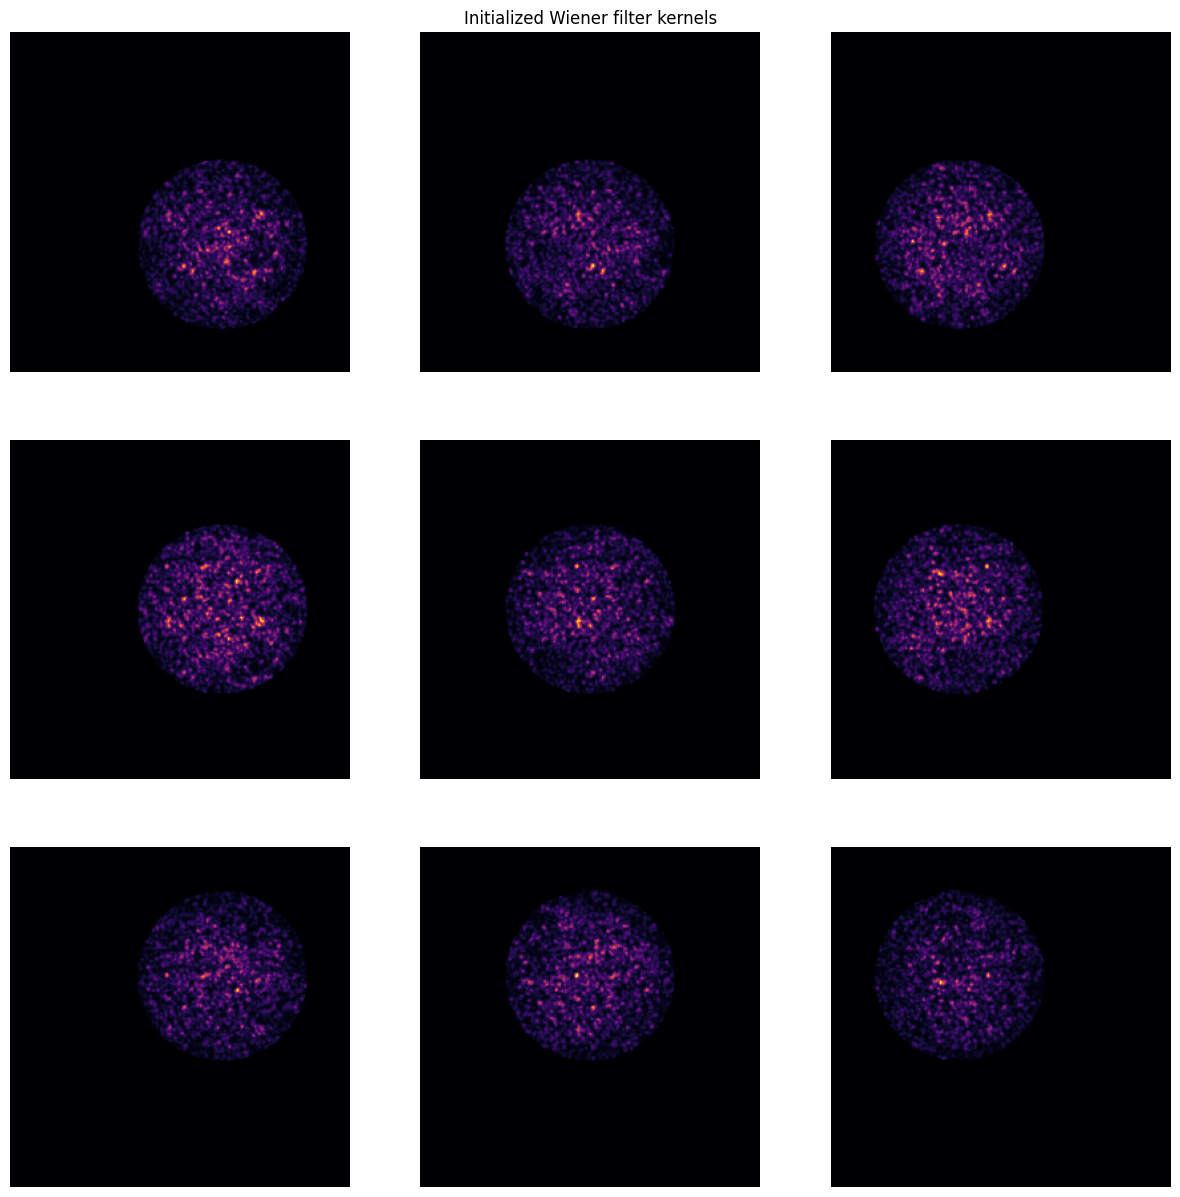

In [7]:
if args.data_type == '3D':
    from models.unet3d import Unet
    unet_model = Unet(n_channel_in=args.psf_num, n_channel_out=1, residual=False, down='conv', up='tconv', activation='selu').to(device)

    if args.network == 'multiwiener' or args.network == 'wiener':
        wiener_model=wm.WienerDeconvolution3D(psfs,Ks).to(device)
        model=wm.MyEnsemble(wiener_model,unet_model)
    else:
        model = unet_model
else: #2D
    from models.unet import Unet_5
    if args.network == 'multiwiener':
        num_in_channels = args.psf_num
    else:
        num_in_channels = 1
        
    
    unet_model = Unet_5(n_channel_in=num_in_channels, n_channel_out=1, residual=False, down='conv', up='tconv', activation='selu').to(device)

    if args.network == 'multiwiener' or args.network == 'wiener':
        wiener_model=wm.WienerDeconvolution3D(psfs,Ks).to(device)
        model=wm.MyEnsemble(wiener_model,unet_model)
        if args.network == 'multiwiener':
            f, axs = plt.subplots(3, 3, figsize=(15,15))
            axs[0, 0].imshow(model.wiener_model.psfs[0,:,:].detach().cpu().numpy())
            axs[0, 0].set_axis_off()
            axs[0, 1].imshow(model.wiener_model.psfs[1,:,:].detach().cpu().numpy())
            axs[0, 1].set_title('Initialized Wiener filter kernels')
            axs[0, 1].set_axis_off()
            axs[0, 2].imshow(model.wiener_model.psfs[2,:,:].detach().cpu().numpy())
            axs[0, 2].set_axis_off()
            axs[1, 0].imshow(model.wiener_model.psfs[3,:,:].detach().cpu().numpy())
            axs[1, 0].set_axis_off()
            axs[1, 1].imshow(model.wiener_model.psfs[4,:,:].detach().cpu().numpy())
            axs[1, 1].set_axis_off()
            axs[1, 2].imshow(model.wiener_model.psfs[5,:,:].detach().cpu().numpy())
            axs[1, 2].set_axis_off()
            axs[2, 0].imshow(model.wiener_model.psfs[6,:,:].detach().cpu().numpy())
            axs[2, 0].set_axis_off()
            axs[2, 1].imshow(model.wiener_model.psfs[7,:,:].detach().cpu().numpy())
            axs[2, 1].set_axis_off()
            axs[2, 2].imshow(model.wiener_model.psfs[8,:,:].detach().cpu().numpy())
            axs[2, 2].set_axis_off()
            plt.savefig(filepath_save + 'pre_psfs.png')
            plt.show()
        elif args.network == 'wiener':          
            plt.imshow(model.wiener_model.psfs[:,:].detach().cpu().numpy())
    elif args.network == 'slp':
        model = SLP(128,128).to(device)
    else:
        model = unet_model

if args.multi_gpu == True:
    model = nn.DataParallel(model)
        
if args.load_path is not None:
    model.load_state_dict(torch.load('saved_data/'+args.load_path,map_location=torch.device(device)))
    print('loading saved model')

if args.loss_type == 'l1' or args.loss_type == 'l1+ssim' or args.loss_type == 'l1+cc':
    loss_fn = torch.nn.L1Loss()
else:
    loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr = args.lr)

In [8]:
if args.save_checkponts == True:
    with open(filepath_save + 'args.json', 'w') as fp:
        json.dump(vars(args), fp)

In [ ]:
best_loss=27e7
ssim_loss=SSIM(win_size=11, win_sigma=1.5, data_range=1, size_average=True, channel=1)
#cc_loss = hp.CCLoss()

train_loss = []
valid_loss = []
epoch_count = []

early_stopper = hp.EarlyStopper(patience=args.val_patience, min_delta=0)
start = time.time()

for itr in range(0,args.epochs):
    mean_train_loss = 0
    for i_batch, sample_batched in enumerate(dataloader_train):
        optimizer.zero_grad()
        #out = model(sample_batched['meas'].repeat(1,32,1,1)[...,18:466,4:644].unsqueeze(0).to(device))
        if args.network=='unet' and args.data_type == '3D':
            out = model(sample_batched['meas'].repeat(1,1,32,1,1).to(device))
        else:
            if args.network=='wiener' or args.network=='multiwiener':
                out, wiener_out = model(sample_batched['meas'].to(device))
            else:
                out = model(sample_batched['meas'].to(device))

        if args.loss_type=='l1':
            loss = loss_fn(out, sample_batched['im_gt'].to(device))
            print('Training epoch: ', itr, ', Batch: ', i_batch, ', Loss (L1): ', format(loss.item(), '.4g'), '      ', end='\r')
        elif args.loss_type=='l2':
            loss = loss_fn(out, sample_batched['im_gt'].to(device))
            print('Training epoch: ', itr, ', Batch: ', i_batch, ', Loss (L2): ', format(loss.item(), '.4g'), '      ', end='\r')    
        else:                
            loss_2 = 1-ssim_loss(out, sample_batched['im_gt'].to(device))
            #loss_2 = cc_loss(out, sample_batched['im_gt'].to(device))
            loss = loss_fn(out, sample_batched['im_gt'].to(device)) + loss_2
            print('Training epoch: ', itr, ', Batch: ', i_batch, ', Loss: ', format(loss.item(), '.4g'), ', Loss (SSIM): ', format(loss_2.item(), '.4g'), '      ', end='\r')
        loss.backward()        
        optimizer.step()
        mean_train_loss+=loss.item()/math.ceil(len(filepath_train)/args.mbs)
    
    if itr%1==0:
        mean_valid_loss=0
        for i_batch, sample_batched in enumerate(dataloader_valid):
            with torch.no_grad():
                if args.network=='unet' and args.data_type == '3D':
                    out = model(sample_batched['meas'].repeat(1,1,32,1,1).to(device))
                else:
                    if args.network=='wiener' or args.network=='multiwiener':
                        out, wiener_out = model(sample_batched['meas'].to(device))
                    else:
                        out = model(sample_batched['meas'].to(device))
                if args.loss_type=='l1':
                    loss = loss_fn(out, sample_batched['im_gt'].to(device))
                elif args.loss_type=='l2':
                    loss = loss_fn(out, sample_batched['im_gt'].to(device))
                else:
                    loss_2 = (1-ssim_loss(out, sample_batched['im_gt'].to(device)))
                    #loss_2 = cc_loss(out, sample_batched['im_gt'].to(device))
                    loss = loss_fn(out, sample_batched['im_gt'].to(device)) + loss_2
                
                mean_valid_loss+=loss.item()/math.ceil(len(filepath_test)/args.mbs)

                print('Epoch: ', itr, ', Batch: ', i_batch, ', Mean Train Loss: ', format(mean_train_loss, '.4g'), ', Mean Valid Loss: ', format(mean_valid_loss, '.4g'), '     ', end='\r')
                
            #break
            
        print('\n')
        
        epoch_count.append(itr)
        train_loss.append(mean_train_loss)
        valid_loss.append(mean_valid_loss)
        
        if mean_valid_loss<best_loss:
            best_loss=mean_valid_loss

            # save checkpoint
            if args.save_checkponts == True:
                torch.save(model.state_dict(), filepath_save + 'model.pt')
        
        plt.plot(epoch_count, train_loss, label='Train loss')
        plt.plot(epoch_count, valid_loss, label='Valid loss')
        plt.title('Training progress (best validation loss: ' + format(best_loss, '.4g') + ')')
        plt.ylabel('Loss')
        ax = plt.gca()
        ax.set_ylim([0, None])
        plt.xlabel('Epoch')
        plt.legend()
        plt.savefig(filepath_save + 'loss.png')
        
        if args.show_valid_rec == True:
            if args.data_type == '3D':
                out_np = np.max(out.detach().cpu().numpy()[0,0],0)
                gt_np = np.max(sample_batched['im_gt'].detach().cpu().numpy()[0,0],0)
                meas_np = np.max(sample_batched['meas'].detach().cpu().numpy()[0,0],0)
            else:
                out_np = out.detach().cpu().numpy()[0][0]
                gt_np = sample_batched['im_gt'].detach().cpu().numpy()[0][0]
                meas_np = sample_batched['meas'].detach().cpu().numpy()[0][0]

            psnr_valid = cv2.PSNR(255*out_np,255*gt_np)
            corr_valid = hp.corr2(out_np,gt_np)
            ssim_valid = structural_similarity(out_np,gt_np,data_range=1,gaussian_weights=True,sigma=1.5)
            #print('PSNR: ', format(psnr_valid, '.4g'), ' dB, SSIM: ', format(ssim_valid, '.4g'), ', CC: ', format(corr_valid, '.4g'), '\n')
            f, ax = plt.subplots(1, 3, figsize=(15,15))
            im_gt_ = ax[0].imshow(gt_np)
            ax[0].set_axis_off()
            plt.colorbar(im_gt_, ax=ax[0], shrink=0.25)
            im_meas_ = ax[1].imshow(meas_np)
            ax[1].set_axis_off()
            ax[1].set_title('PSNR: ' + format(psnr_valid, '.4g') + ' dB, SSIM: ' + format(ssim_valid, '.4g') + ', CC: ' + format(corr_valid, '.4g'))
            plt.colorbar(im_meas_, ax=ax[1], shrink=0.25)
            im_out_ = ax[2].imshow(out_np)
            ax[2].set_axis_off()
            plt.colorbar(im_out_, ax=ax[2], shrink=0.25)
            plt.show()

            if args.network == 'multiwiener':
                f, axs = plt.subplots(1, 9, figsize=(15,15))
                axs[0].imshow(wiener_out[0,0,:,:].detach().cpu().numpy())
                axs[0].set_axis_off()
                axs[1].imshow(wiener_out[0,1,:,:].detach().cpu().numpy())
                axs[1].set_axis_off()
                axs[2].imshow(wiener_out[0,2,:,:].detach().cpu().numpy())
                axs[2].set_axis_off()
                axs[3].imshow(wiener_out[0,3,:,:].detach().cpu().numpy())
                axs[3].set_axis_off()
                axs[4].imshow(wiener_out[0,4,:,:].detach().cpu().numpy())
                axs[4].set_axis_off()
                axs[4].set_title('Wiener filter outputs')
                axs[5].imshow(wiener_out[0,5,:,:].detach().cpu().numpy())
                axs[5].set_axis_off()
                axs[6].imshow(wiener_out[0,6,:,:].detach().cpu().numpy())
                axs[6].set_axis_off()
                axs[7].imshow(wiener_out[0,7,:,:].detach().cpu().numpy())
                axs[7].set_axis_off()
                axs[8].imshow(wiener_out[0,8,:,:].detach().cpu().numpy())
                axs[8].set_axis_off()
                plt.show()
            elif args.network == 'wiener':          
                plt.imshow(wiener_out[0,0,:,:].detach().cpu().numpy())    
        
        #if mean_valid_loss<best_loss:
            #best_loss=mean_valid_loss

            # save checkpoint
            #if args.save_checkponts == True:
                #torch.save(model.state_dict(), filepath_save + 'model.pt')
    if early_stopper.early_stop(mean_valid_loss):
        print('Stopped training early\n')
        
        break
    print('\n')

In [ ]:
end = time.time()
training_time = end - start
print('Training time: ', format(training_time, '.0f'), ' s')

training_info = {'epochs': epoch_count, 'training_time': training_time, 'train_loss': train_loss, 'valid_loss': valid_loss}
savemat(filepath_save + 'training_info.mat',training_info)

In [ ]:
eval_test = {'psnr_test': [], 'ssim_test': [], 'corr_test': []}
#model.load_state_dict(torch.load(filepath_save + 'model.pt'))

for i_batch, sample_batched in enumerate(dataloader_test):
    if args.network=='unet' and args.data_type == '3D':
        out = model(sample_batched['meas'].repeat(1,1,32,1,1).to(device))
    else:
        if args.network=='wiener' or args.network=='multiwiener':
            out, wiener_out = model(sample_batched['meas'].to(device))
        else:
            out = model(sample_batched['meas'].to(device))
                    
    out_np = out.detach().cpu().numpy()[0][0]
    gt_np = sample_batched['im_gt'].detach().cpu().numpy()[0][0]
    
    eval_test['psnr_test'].append(cv2.PSNR(255*out_np,255*gt_np))
    eval_test['ssim_test'].append(structural_similarity(out_np,gt_np,data_range=1,gaussian_weights=True,sigma=1.5))
    eval_test['corr_test'].append(hp.corr2(out_np,gt_np))
    
eval_test['psnr_mean'] = statistics.mean(eval_test['psnr_test'])
eval_test['psnr_median'] = statistics.median(eval_test['psnr_test'])
eval_test['psnr_std'] = statistics.pstdev(eval_test['psnr_test'])

eval_test['ssim_mean'] = statistics.mean(eval_test['ssim_test'])
eval_test['ssim_median'] = statistics.median(eval_test['ssim_test'])
eval_test['ssim_std'] = statistics.pstdev(eval_test['ssim_test'])

eval_test['corr_mean'] = statistics.mean(eval_test['corr_test'])
eval_test['corr_median'] = statistics.median(eval_test['corr_test'])
eval_test['corr_std'] = statistics.pstdev(eval_test['corr_test'])

print('PSNR mean:', format(eval_test['psnr_mean'], '.4g'), 'dB, median:', format(eval_test['psnr_median'], '.4g'), 'dB, std:', format(eval_test['psnr_std'], '.4g'), 'dB')
print('SSIM mean:', format(eval_test['ssim_mean'], '.4g'), ', median:', format(eval_test['ssim_median'], '.4g'), ', std:', format(eval_test['ssim_std'], '.4g'), '')
print('CC mean:', format(eval_test['corr_mean'], '.4g'), ', median:', format(eval_test['corr_median'], '.4g'), ', std:', format(eval_test['corr_std'], '.4g'), '\n')
    
f, ax = plt.subplots(1,3, figsize=(15,4))
ax[0].boxplot(eval_test['psnr_test'])
ax[0].title.set_text('PSNR [dB], Median: ' + format(eval_test['psnr_median'], '.4g') + 'dB')
ax[1].boxplot(eval_test['ssim_test'])
ax[1].title.set_text('SSIM, Median: ' + format(eval_test['ssim_median'], '.4g'))
ax[2].boxplot(eval_test['corr_test'])
ax[2].title.set_text('CC, Median: ' + format(eval_test['corr_median'], '.4g'))
ax[0].violinplot(eval_test['psnr_test'])
ax[1].violinplot(eval_test['ssim_test'])
ax[2].violinplot(eval_test['corr_test'])
plt.savefig(filepath_save + 'eval.png')
plt.show()

savemat(filepath_save + 'eval_test.mat',eval_test)

In [ ]:
i_ = random.randint(0,len(filepath_test)-1)
print(i_)
sample = dataset_test.__getitem__(i_)
meas_np = hp.to_np(sample_batched['meas'])
sample['meas'] = sample['meas'].unsqueeze(0)
sample['im_gt'] = sample['im_gt'].unsqueeze(0)
out, wiener_out = model(sample['meas'].to(device))
out_np = out.detach().cpu().numpy()[0][0]
gt_np = sample['im_gt'].detach().cpu().numpy()[0][0]
meas_np = sample['meas'].detach().cpu().numpy()[0][0]

f, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(gt_np, vmin = 0, vmax = 1)
ax[0].set_axis_off()
ax[0].set_title('Ground Truth')
ax[1].imshow(meas_np, vmin = 0, vmax = 1)
ax[1].set_axis_off()
ax[1].set_title('Camera Image')
ax[2].imshow(out_np, vmin = 0, vmax = 1)
ax[2].set_axis_off()
ax[2].set_title('Reconstruction')
plt.savefig(filepath_save + 'rec_' + str(i_) + '.png')

if args.network == 'multiwiener':
    f, axs = plt.subplots(1, 9, figsize=(15,15))
    plt.axis('off')
    axs[0].imshow(wiener_out[0,0,:,:].detach().cpu().numpy())
    axs[0].set_axis_off()
    axs[1].imshow(wiener_out[0,1,:,:].detach().cpu().numpy())
    axs[1].set_axis_off()
    axs[2].imshow(wiener_out[0,2,:,:].detach().cpu().numpy())
    axs[2].set_axis_off()
    axs[3].imshow(wiener_out[0,3,:,:].detach().cpu().numpy())
    axs[3].set_axis_off()
    axs[4].imshow(wiener_out[0,4,:,:].detach().cpu().numpy())
    axs[4].set_axis_off()
    axs[4].set_title('Wiener filter outputs')
    axs[5].imshow(wiener_out[0,5,:,:].detach().cpu().numpy())
    axs[5].set_axis_off()
    axs[6].imshow(wiener_out[0,6,:,:].detach().cpu().numpy())
    axs[6].set_axis_off()
    axs[7].imshow(wiener_out[0,7,:,:].detach().cpu().numpy())
    axs[7].set_axis_off()
    axs[8].imshow(wiener_out[0,8,:,:].detach().cpu().numpy())
    axs[8].set_axis_off()
    plt.savefig(filepath_save + 'wienerout_' + str(i_) + '.png')

In [ ]:
if args.network=='multiwiener':
    f, axs = plt.subplots(3, 3, figsize=(15,15))
    axs[0, 0].imshow(model.wiener_model.psfs[0,:,:].detach().cpu().numpy())
    axs[0, 0].set_axis_off()
    axs[0, 1].imshow(model.wiener_model.psfs[1,:,:].detach().cpu().numpy())
    axs[0, 1].set_title('Learned Wiener filter kernels')
    axs[0, 1].set_axis_off()
    axs[0, 2].imshow(model.wiener_model.psfs[2,:,:].detach().cpu().numpy())
    axs[0, 2].set_axis_off()
    axs[1, 0].imshow(model.wiener_model.psfs[3,:,:].detach().cpu().numpy())
    axs[1, 0].set_axis_off()
    axs[1, 1].imshow(model.wiener_model.psfs[4,:,:].detach().cpu().numpy())
    axs[1, 1].set_axis_off()
    axs[1, 2].imshow(model.wiener_model.psfs[5,:,:].detach().cpu().numpy())
    axs[1, 2].set_axis_off()
    axs[2, 0].imshow(model.wiener_model.psfs[6,:,:].detach().cpu().numpy())
    axs[2, 0].set_axis_off()
    axs[2, 1].imshow(model.wiener_model.psfs[7,:,:].detach().cpu().numpy())
    axs[2, 1].set_axis_off()
    axs[2, 2].imshow(model.wiener_model.psfs[8,:,:].detach().cpu().numpy())
    axs[2, 2].set_axis_off()
    plt.savefig(filepath_save + 'learned_psf.png')
    plt.show()

In [ ]:
print(model)

In [ ]:
torch.cuda.empty_cache()